In [1]:
from aeon.datasets import load_airline
#!pip install -U aeon
#!pip install aeon[all_extras]
import warnings
import pandas as pd
import numpy as np
from aeon.datasets import load_airline
# from aeon.forecasting.arima import ARIMA
from matplotlib import pyplot as plt
from aeon.forecasting.arima import AutoARIMA
from aeon.forecasting.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from aeon.visualisation import plot_series
from aeon.transformations.detrend import Deseasonalizer
from all_functions import *
warnings.filterwarnings("ignore")
%matplotlib inline
horizon = 12

def mcpm_func(rmse_result, mape_result, pocid_result):
  er_result = 100 - pocid_result

  A1 = (rmse_result * mape_result * np.sin((2*np.pi)/3))/2
  A2 = (mape_result * er_result * np.sin((2*np.pi)/3))/2
  A3 = (er_result * rmse_result * np.sin((2*np.pi)/3))/2
  total = A1 + A2 + A3
  return total

/home/anp/anaconda3/lib/python3.11/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


In [2]:
import os

# pastas = [ 
#           './Statistics_and_Seq2Seq/results/arima/rolling/gasolinac',
#           './Statistics_and_Seq2Seq/results/arima/rolling/oleodiesel',
#           './Statistics_and_Seq2Seq/results/arima/rolling/etanolhidratado',
#           './Statistics_and_Seq2Seq/results/arima/rolling/gasolinadeaviacao',
#           './Statistics_and_Seq2Seq/results/arima/rolling/glp',
#           './Statistics_and_Seq2Seq/results/arima/rolling/oleocombustivel',
#           './Statistics_and_Seq2Seq/results/arima/rolling/querosenedeaviacao',
#           './Statistics_and_Seq2Seq/results/arima/rolling/queroseneiluminante'
#           ]

pastas = [
          '../results/varma/rolling/gasolinac',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/oleodiesel',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/etanolhidratado',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/gasolinadeaviacao',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/glp',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/oleocombustivel',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/querosenedeaviacao',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/queroseneiluminante'
          ]


dfs_por_transformacao = {}

for pasta in pastas:
    if os.path.isdir(pasta):
        for arquivo in os.listdir(pasta):
            if arquivo.endswith('.csv'):
                caminho_arquivo = os.path.join(pasta, arquivo)
                df = pd.read_csv(caminho_arquivo, delimiter=';')
                
                for transformacao, grupo in df.groupby('DATA'):
                    if transformacao not in dfs_por_transformacao:
                        dfs_por_transformacao[transformacao] = grupo.copy()
                    else:
                        dfs_por_transformacao[transformacao] = pd.concat(
                            [dfs_por_transformacao[transformacao], grupo], ignore_index=True
                        )


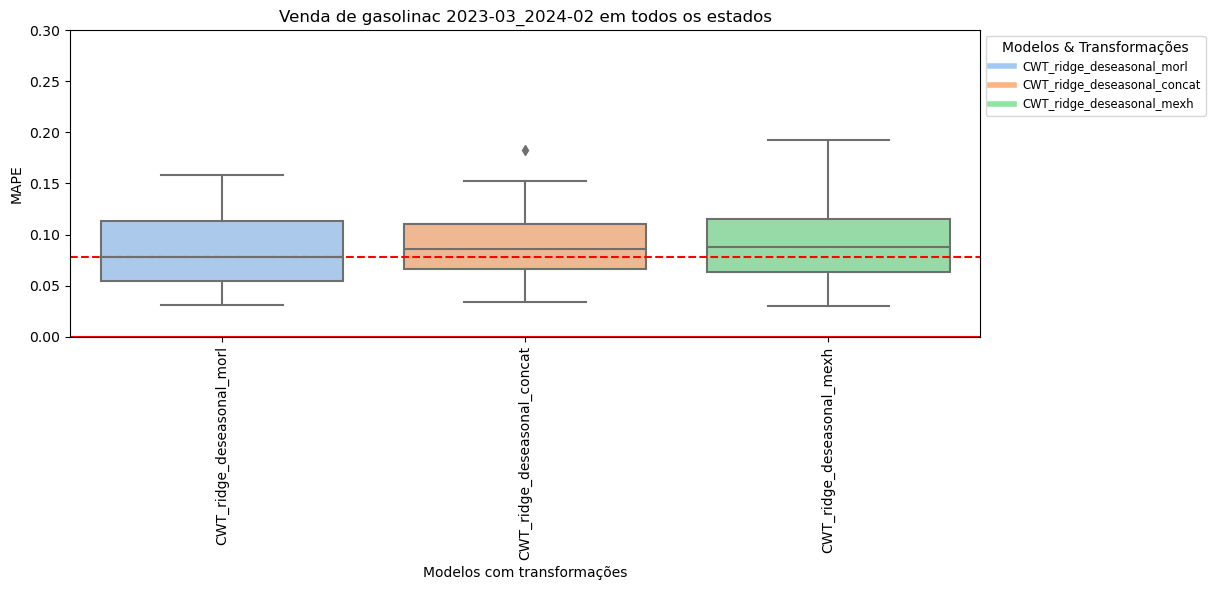

In [12]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

path_data = "../datasets/venda/mensal/uf"
# cores_uf = {
#     'AC': 'green', 'AL': 'green', 'AP': 'green', 'AM': 'green', 'BA': 'green',
#     'CE': 'green', 'DF': 'green', 'ES': 'green', 'GO': 'green', 'MA': 'green',
#     'MT': 'green', 'MS': 'green', 'MG': 'green', 'PA': 'green', 'PB': 'green',
#     'PR': 'blue', 'PE': 'green', 'PI': 'green', 'RJ': 'green', 
#     'RN': 'green', 'RS': 'green', 'RO': 'green', 'RR': 'green', 
#     'SC': 'green', 'SP': 'red', 'SE': 'green', 'TO': 'green'
# }

def safe_eval(preds):
    try:
        # Remover quebras de linha e espaços desnecessários
        preds_clean = preds.replace('\n', ' ').replace('  ', ' ')
        # Remover espaços entre números
        preds_clean = ' '.join(preds_clean.split())
        preds_clean = preds_clean.replace(' ', ',')
        return ast.literal_eval(preds_clean)
    except Exception as e:
        print(f"Erro ao converter: {e}")
        return None
cores_uf = {
    'AC': 'red', 'AL': 'green', 'AP': 'blue', 'AM': 'yellow', 'BA': 'orange',
    'CE': 'purple', 'DF': 'brown', 'ES': 'pink', 'GO': 'gray', 'MA': 'olive',
    'MT': 'cyan', 'MS': 'magenta', 'MG': 'lime', 'PA': 'black', 'PB': 'navy',
    'PR': 'teal', 'PE': 'darkorange', 'PI': 'royalblue', 'RJ': 'salmon', 
    'RN': 'lightgreen', 'RS': 'violet', 'RO': 'gold', 'RR': 'sienna', 
    'SC': 'skyblue', 'SP': 'darkred', 'SE': 'dodgerblue', 'TO': 'tomato'
}

data_test = {}
data_preds = {}
def ler_dados(pastas_filtros):
    dfs_por_transformacao = []
    
    for item in pastas_filtros:
        pasta, filtro_data, coluna_filtro, label = item['pasta'], item['filtro'], item['coluna_filtro'], item['label']
        if os.path.isdir(pasta):
            for arquivo in os.listdir(pasta):
                if arquivo.endswith('.csv'):
                    derivado = pasta.split("/")[-1]
                    uf = arquivo.split("_")[1][:2]
                    caminho_arquivo = os.path.join(pasta, arquivo)
                    df = pd.read_csv(caminho_arquivo, sep=';')
                    # series = read_series(path_data+"/"+derivado+f"/mensal_{uf.lower()}_{derivado}.csv")
                    # train, test = train_test_stats(series, horizon)
                    # y_baseline = series[-horizon*2:-horizon].values
                    # data_test[f'{pasta.split("/")[2]+"-"+filtro_data}_{uf}'] = test
                    df_filtrado = df[df[coluna_filtro] == filtro_data]
                    if 'PREDS' in df_filtrado.columns:
                        predictions = df_filtrado['PREDS'].apply(safe_eval)
                        print(predictions)
                    else:
                        predictions = df_filtrado.loc[:, 'P1':'P12']
                        predictions = predictions.values.flatten().tolist()
                    # predictions = pd.Series(predictions, index=test.index)
                    # data_preds[f'{pasta.split("/")[3]+"-"+filtro_data}_{uf}'] = predictions
                    # mase_result = mase(test, predictions, y_baseline)
                    # df_filtrado["MASE"] = mase_result
                    df_filtrado['Filtro'] = label
                    dfs_por_transformacao.append(df_filtrado)
    
    return pd.concat(dfs_por_transformacao, ignore_index=True)

def gerar_boxplot(df, coluna_metrica, title="-", x_label = "Filters", cores_uf=None):
    plt.figure(figsize=(10, 6))
    
    if coluna_metrica == 'POCID':
        quartis = df.groupby('Filtro')[coluna_metrica].quantile(0.75)
        ordenacao_quartil = quartis.sort_values(ascending=False).index
        
        df['Filtro'] = pd.Categorical(df['Filtro'], categories=ordenacao_quartil, ordered=True)
        ordenacao = ordenacao_quartil
    else:
        medianas = df.groupby('Filtro')[coluna_metrica].median()
        proximidade_mediana = (medianas - 0).abs()
        ordenacao_mediana = proximidade_mediana.sort_values().index
        
        df['Filtro'] = pd.Categorical(df['Filtro'], categories=ordenacao_mediana, ordered=True)
        ordenacao = ordenacao_mediana

    # Criando boxplot
    sns.boxplot(x='Filtro', y=coluna_metrica, data=df, palette='pastel', order=df['Filtro'].cat.categories)
    
    # Adicionando pontos sobre o boxplot
    # sns.stripplot(x='Filtro', y=coluna_metrica, data=df, palette='dark', jitter=True, alpha=0.5, dodge=False, order=df['Filtro'].cat.categories)


    plt.title(f"{title}")
    plt.xlabel(x_label)
    plt.ylabel(coluna_metrica)
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Ajustando os limites do eixo y
    if coluna_metrica == 'MAPE':
        plt.ylim(0, 0.6) if abs(max(medianas.values)) > 0.2 else plt.ylim(0, 0.3)
    elif coluna_metrica == 'PBE':
        plt.ylim(-40, 70) if abs(max(medianas.values)) > 20 else plt.ylim(-20, 20)
    elif coluna_metrica == 'POCID':
        plt.ylim(0, 100)
    
    plt.axhline(y=0, color='red', linestyle='-')  

    # Linha horizontal na mediana mais próxima
    mediana_prox = quartis.loc[ordenacao[0]] if coluna_metrica == 'POCID' else medianas.loc[ordenacao[0]]
    plt.axhline(y=mediana_prox, color='red', linestyle='--')  

    # Criando a legenda
    if cores_uf:
        # Ajustar a paleta de cores usando as cores de cores_uf, repetindo se necessário
        palette = [cores_uf[i % len(cores_uf)] for i in range(len(ordenacao))]
    else:
        palette = sns.color_palette("pastel", n_colors=len(ordenacao))  # Fallback para uma paleta padrão

    filtro_handles = [plt.Line2D([0], [0], color=palette[i], lw=4, label=filtro) for i, filtro in enumerate(ordenacao)]
    
    plt.legend(handles=filtro_handles, title='Modelos & Transformações', bbox_to_anchor=(1, 1), loc='upper left', fontsize='small')
    
    plt.show()

produto = "gasolinac"
filtro = '2023-03_2024-02'
resultado_pasta = 'results'
pastas_filtros = [

    # {'pasta': f'./results/arima/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'arima_normal'},
    # {'pasta': f'./results/arima/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'arima_log'},
    # {'pasta': f'./results/arima/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'arima_deseasonal'},


    # {'pasta': f'./paper_roma/CWT_ridge_morl/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'CWT_ridge_normal_morl'},
    # {'pasta': f'./paper_roma/CWT_ridge_morl/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'CWT_ridge_log_morl'},
    {'pasta': f'./paper_roma/CWT_ridge_morl/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'CWT_ridge_deseasonal_morl'},

    # {'pasta': f'./paper_roma/CWT_ridge_mexh/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'CWT_ridge_normal_mexh'},
    # {'pasta': f'./paper_roma/CWT_ridge_mexh/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'CWT_ridge_log_mexh'},
    {'pasta': f'./paper_roma/CWT_ridge_mexh/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'CWT_ridge_deseasonal_mexh'},

    # {'pasta': f'./paper_roma/CWT_ridge_concat/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'CWT_ridge_normal_concat'},
    # {'pasta': f'./paper_roma/CWT_ridge_concat/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'CWT_ridge_log_concat'},
    {'pasta': f'./paper_roma/CWT_ridge_concat/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'CWT_ridge_deseasonal_concat'},


    # {'pasta': f'./paper_roma/SWT_ridge_db1_lvl2/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'SWT_ridge_normal_db1_lvl2'},
    # {'pasta': f'./paper_roma/SWT_ridge_db1_lvl2/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'SWT_ridge_log_db1_lvl2'},
    # {'pasta': f'./paper_roma/SWT_ridge_db1_lvl2/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'SWT_ridge_deseasonal_db1_lvl2'},

    # {'pasta': f'./paper_roma/SWT_ridge_db2_lvl2/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'SWT_ridge_normal_db2_lvl2'},
    # {'pasta': f'./paper_roma/SWT_ridge_db2_lvl2/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'SWT_ridge_log_db2_lvl2'},
    # {'pasta': f'./paper_roma/SWT_ridge_db2_lvl2/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'SWT_ridge_deseasonal_db2_lvl2'},


    # {'pasta': f'./paper_roma/DWT_ridge_db4_lvl4/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_normal_db4_lvl4'},
    # {'pasta': f'./paper_roma/DWT_ridge_db4_lvl4/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_log_db4_lvl4'},
    # {'pasta': f'./paper_roma/DWT_ridge_db4_lvl4/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_deseasonal_db4_lvl4'},

    # {'pasta': f'./paper_roma/DWT_ridge_db1_lvl4/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_normal_db1_lvl4'},
    # {'pasta': f'./paper_roma/DWT_ridge_db1_lvl4/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_log_db1_lvl4'},
    # {'pasta': f'./paper_roma/DWT_ridge_db1_lvl4/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_deseasonal_db1_lvl4'},

    #  {'pasta': f'./paper_roma/DWT_ridge_db2_lvl4/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_normal_db2_lvl4'},
    # {'pasta': f'./paper_roma/DWT_ridge_db2_lvl4/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_log_db2_lvl4'},
    # {'pasta': f'./paper_roma/DWT_ridge_db2_lvl4/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_deseasonal_db2_lvl4'},
    
    # {'pasta': f'./paper_roma/DWT_ridge_db3_lvl4/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_normal_db3_lvl4'},
    # {'pasta': f'./paper_roma/DWT_ridge_db3_lvl4/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_log_db3_lvl4'},
    # {'pasta': f'./paper_roma/DWT_ridge_db3_lvl4/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_deseasonal_db3_lvl4'},
    
    # {'pasta': f'./paper_roma/DWT_ridge_db5_lvl4/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_normal_db5_lvl4'},
    # {'pasta': f'./paper_roma/DWT_ridge_db5_lvl4/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_log_db5_lvl4'},
    # {'pasta': f'./paper_roma/DWT_ridge_db5_lvl4/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_deseasonal_db5_lvl4'},

    # {'pasta': f'./paper_roma/DWT_ridge_db6_lvl4/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_normal_db6_lvl4'},
    # {'pasta': f'./paper_roma/DWT_ridge_db6_lvl4/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_log_db6_lvl4'},
    # {'pasta': f'./paper_roma/DWT_ridge_db6_lvl4/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_deseasonal_db6_lvl4'},


    # {'pasta': f'./paper_roma/DWT_ridge_db1_lvl2/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_normal_db1_lvl2'},
    # {'pasta': f'./paper_roma/DWT_ridge_db1_lvl2/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_log_db1_lvl2'},
    # {'pasta': f'./paper_roma/DWT_ridge_db1_lvl2/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_deseasonal_db1_lvl2'},

    # {'pasta': f'./paper_roma/DWT_ridge_db1_lvl6/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_normal_db1_lvl6'},
    # {'pasta': f'./paper_roma/DWT_ridge_db1_lvl6/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_log_db1_lvl6'},
    # {'pasta': f'./paper_roma/DWT_ridge_db1_lvl6/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_deseasonal_db1_lvl6'},

    # {'pasta': f'./paper_roma/DWT_ridge_db2_lvl2/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_normal_db2_lvl2'},
    # {'pasta': f'./paper_roma/DWT_ridge_db2_lvl2/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_log_db2_lvl2'},
    # {'pasta': f'./paper_roma/DWT_ridge_db2_lvl2/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_deseasonal_db2_lvl2'},

    #  {'pasta': f'./paper_roma/DWT_ridge_db3_lvl2/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_normal_db3_lvl2'},
    # {'pasta': f'./paper_roma/DWT_ridge_db3_lvl2/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_log_db3_lvl2'},
    # {'pasta': f'./paper_roma/DWT_ridge_db3_lvl2/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_deseasonal_db3_lvl2'},

    #  {'pasta': f'./paper_roma/DWT_ridge_db4_lvl2/{produto}/normal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_normal_db4_lvl2'},
    # {'pasta': f'./paper_roma/DWT_ridge_db4_lvl2/{produto}/log', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_log_db4_lvl2'},
    # {'pasta': f'./paper_roma/DWT_ridge_db4_lvl2/{produto}/deseasonal', 'filtro': filtro, 'coluna_filtro': 'test_range', 'label': 'DWT_ridge_deseasonal_db4_lvl2'},

]
coluna_metrica = "MAPE"  #"MCPM", "PBE", "RMSE", "POCID" ou "MAPE"

df_consolidado = ler_dados(pastas_filtros)

gerar_boxplot(df_consolidado, coluna_metrica, title=f"Venda de {produto} {filtro} em todos os estados", x_label="Modelos com transformações")


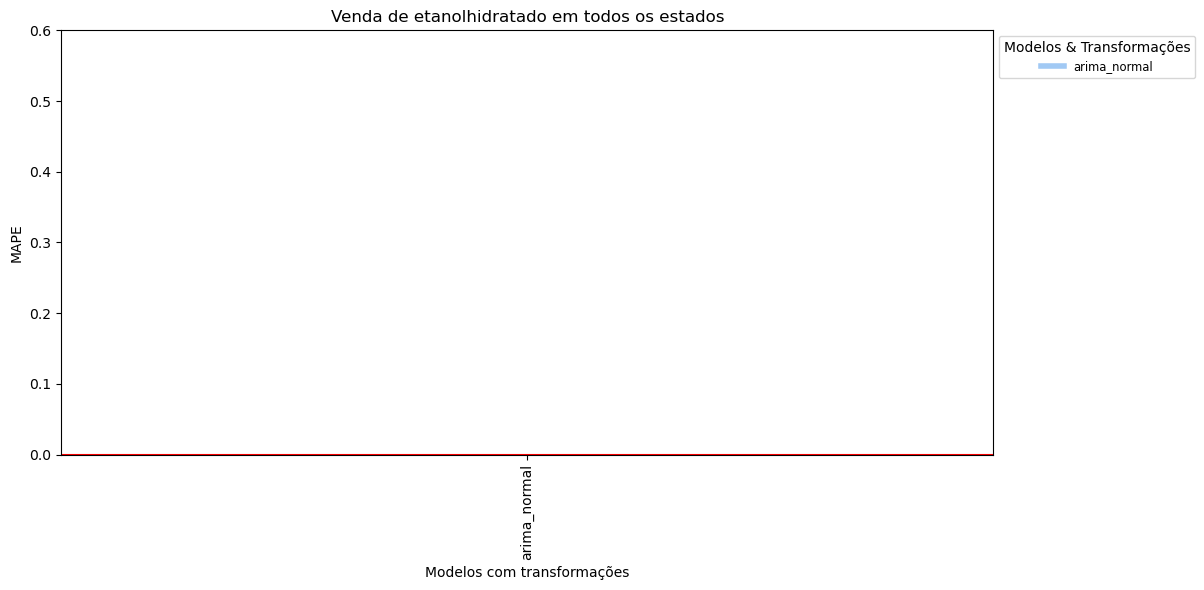

In [4]:
produto = "etanolhidratado"
filtro = 'normal'
pastas_filtros = [

    {'pasta': f'./error_preds/arima/{produto}/meta_rf/2023-03_2024-02', 'filtro': filtro, 'coluna_filtro': 'DATA', 'label': 'arima_normal'},
]
coluna_metrica = "MAPE"  #"MCPM", "PBE", "RMSE", "POCID" ou "MAPE"

df_consolidado = ler_dados(pastas_filtros)

gerar_boxplot(df_consolidado, coluna_metrica, title=f"Venda de {produto} em todos os estados", x_label="Modelos com transformações")

In [5]:
estado = "SP"
derivado = "etanolhidratado"
horizon = 12
window = 36
transform = "normal"
model = "rf"
test_date = '2023-03_2024-02'
test_error = get_error_series(f'./results/{model}/{derivado}/{transform}/transform_{estado}.csv', test_date)

preds_error = get_preds_model(f'./error_preds/{model}/{derivado}/meta_rf/{test_date}/transform_{estado}.csv', transform, 'DATA')
# preds_error.reverse()

In [6]:
test_error2 = get_error_series(f'./results/{model}/{derivado}/{transform}/transform_{estado}.csv',  '2022-03_2023-02')
test_error3 = get_error_series(f'./results/{model}/{derivado}/{transform}/transform_{estado}.csv',  '2021-03_2022-02')

conc = test_error3 + test_error2 + test_error

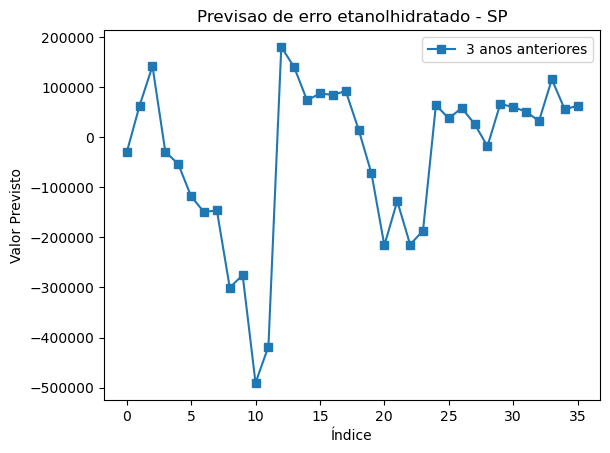

In [7]:
x = range(len(conc))

# plt.plot(x, preds_error, label="Predição do erro", marker='o')
# plt.plot(x, test_error, label="Test do erro", marker='s')
plt.plot(x,conc, label="3 anos anteriores", marker='s')

plt.title(f"Previsao de erro {derivado} - {estado}")
plt.xlabel("Índice")
plt.ylabel("Valor Previsto")

plt.legend()

plt.show()